In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, roc_auc_score, roc_curve, silhouette_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize

import time
from tqdm import tqdm
import copy
import warnings
import os
from PIL import Image
from torch.utils.data import Dataset
import glob
from sklearn.model_selection import train_test_split



warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Dataset Preparation

In [2]:
class NestedImageDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Root directory containing class-wise folders.
        """
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        
        self.class_to_idx = {cls: idx for idx, cls in enumerate(os.listdir(root_dir))}
        
        for class_name in os.listdir(root_dir):
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for img_path in glob.glob(os.path.join(class_folder, '**', '*.*'), recursive=True):
                    if img_path.lower().endswith(('.jpg', '.jpeg', '.png')): 
                        self.image_paths.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")  # Return PIL Image
        return image, label


root_dir = '/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset'

dataset = NestedImageDataset(root_dir=root_dir)

print(f"Total samples in the dataset: {len(dataset)}")
for i in range(5):  
    img, label = dataset[i]
    print(f"Sample {i}: Label {label}, Type: {type(img)}")


if len(dataset.image_paths) > 0:
    train_paths, test_paths = train_test_split(dataset.image_paths, test_size=0.2, random_state=42)

    # Create separate datasets for train and test
    train_dataset = NestedImageDataset(root_dir=root_dir)
    train_dataset.image_paths = train_paths
    train_dataset.labels = [dataset.labels[i] for i in range(len(dataset.image_paths)) if dataset.image_paths[i] in train_paths]

    test_dataset = NestedImageDataset(root_dir=root_dir)
    test_dataset.image_paths = test_paths
    test_dataset.labels = [dataset.labels[i] for i in range(len(dataset.image_paths)) if dataset.image_paths[i] in test_paths]

    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
else:
    print("No images found. Please check your directory structure.")


Total samples in the dataset: 375
Sample 0: Label 0, Type: <class 'PIL.Image.Image'>
Sample 1: Label 0, Type: <class 'PIL.Image.Image'>
Sample 2: Label 0, Type: <class 'PIL.Image.Image'>
Sample 3: Label 0, Type: <class 'PIL.Image.Image'>
Sample 4: Label 0, Type: <class 'PIL.Image.Image'>
Train samples: 300
Test samples: 75


# BYOL Augmentation Pipeline

In [4]:
class BYOLAugmentation:
    """
    BYOL uses two different augmentation pipelines for the same image.
    View 1: Stronger augmentation
    View 2: Weaker augmentation (optional, can be same as view 1)
    """
    def __init__(self, size=32):
        # Stronger augmentation for view 1
        self.transform1 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        
        # View 2 (can be same or slightly different)
        self.transform2 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.08, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
    
    def __call__(self, x):
        return self.transform1(x), self.transform2(x)


class BYOLDataset(Dataset):
    """Wrapper dataset that applies BYOL augmentations"""
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.augment = BYOLAugmentation()
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        view1, view2 = self.augment(img)
        return view1, view2, label


byol_train_dataset = BYOLDataset(train_dataset)
byol_train_loader = DataLoader(byol_train_dataset, batch_size=256, 
                               shuffle=True, num_workers=2, pin_memory=True)

# BYOL Model Architecture

In [5]:
class MLP(nn.Module):
    """Simple MLP for projection and prediction heads"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


class BYOL(nn.Module):
    """
    BYOL uses two networks: online and target.
    Online network: encoder + projector + predictor
    Target network: encoder + projector (no predictor, EMA of online)
    """
    def __init__(self, projection_dim=256, hidden_dim=4096):
        super(BYOL, self).__init__()
        
        # Online network encoder
        self.online_encoder = resnet18(pretrained=False)
        self.online_encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, 
                                               padding=1, bias=False)
        self.online_encoder.maxpool = nn.Identity()
        
        self.feature_dim = self.online_encoder.fc.in_features
        self.online_encoder.fc = nn.Identity()
        
        # Online projector
        self.online_projector = MLP(self.feature_dim, hidden_dim, projection_dim)
        
        # Online predictor
        self.online_predictor = MLP(projection_dim, hidden_dim, projection_dim)
        
        # Target network (copy of online, updated via EMA)
        self.target_encoder = copy.deepcopy(self.online_encoder)
        self.target_projector = copy.deepcopy(self.online_projector)
        
        # Freeze target network
        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False
    
    def forward(self, x1, x2):
        # Online network forward pass
        online_feat1 = self.online_encoder(x1)
        online_proj1 = self.online_projector(online_feat1)
        online_pred1 = self.online_predictor(online_proj1)
        
        online_feat2 = self.online_encoder(x2)
        online_proj2 = self.online_projector(online_feat2)
        online_pred2 = self.online_predictor(online_proj2)
        
        # Target network forward pass (no gradient)
        with torch.no_grad():
            target_feat1 = self.target_encoder(x1)
            target_proj1 = self.target_projector(target_feat1)
            
            target_feat2 = self.target_encoder(x2)
            target_proj2 = self.target_projector(target_feat2)
        
        return online_pred1, online_pred2, target_proj1, target_proj2
    
    @torch.no_grad()
    def update_target_network(self, momentum=0.996):
        """Update target network using exponential moving average"""
        for online_params, target_params in zip(
            self.online_encoder.parameters(), self.target_encoder.parameters()
        ):
            target_params.data = momentum * target_params.data + (1 - momentum) * online_params.data
        
        for online_params, target_params in zip(
            self.online_projector.parameters(), self.target_projector.parameters()
        ):
            target_params.data = momentum * target_params.data + (1 - momentum) * online_params.data


model = BYOL(projection_dim=256, hidden_dim=4096).to(device)
print(f"Encoder feature dimension: {model.feature_dim}")


Encoder feature dimension: 512


In [8]:
def byol_loss(pred, target):
    """
    BYOL loss: negative cosine similarity between predictions and targets
    pred: predictions from online network
    target: projections from target network (detached)
    """
    pred = F.normalize(pred, dim=-1, p=2)
    target = F.normalize(target, dim=-1, p=2)
    return 2 - 2 * (pred * target).sum(dim=-1).mean()


# 5.1 Label free Pretrainning

In [9]:
def train_byol(model, train_loader, epochs=100, lr=3e-4, momentum_start=0.996, momentum_end=1.0):
    """
    Pretrain BYOL using self-supervised learning
    The momentum parameter for EMA is gradually increased from start to end
    """
    optimizer = torch.optim.Adam(
        list(model.online_encoder.parameters()) + 
        list(model.online_projector.parameters()) + 
        list(model.online_predictor.parameters()),
        lr=lr, weight_decay=1e-6
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    model.train()
    losses = []
    
    print("Starting BYOL pretraining...")
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Calculate current momentum
        momentum = momentum_start + (momentum_end - momentum_start) * epoch / epochs
        
        for view1, view2, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            view1, view2 = view1.to(device), view2.to(device)
            
            # Forward pass
            pred1, pred2, target1, target2 = model(view1, view2)
            
            # Compute loss (symmetric)
            loss = byol_loss(pred1, target2) + byol_loss(pred2, target1)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update target network
            model.update_target_network(momentum=momentum)
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Momentum: {momentum:.4f}")
    
    train_time = time.time() - start_time
    print(f"Pretraining completed in {train_time:.2f} seconds")
    
    return losses, train_time


# Train the model
pretrain_losses, pretrain_time = train_byol(model, byol_train_loader, epochs=50)

# Save the pretrained encoder
torch.save(model.online_encoder.state_dict(), 'byol_encoder.pth')
print("Frozen encoder saved!")


Starting BYOL pretraining...


Epoch 1/50: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Epoch 1/50 - Loss: 3.2071, Momentum: 0.9960


Epoch 2/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 2/50 - Loss: 1.8512, Momentum: 0.9961


Epoch 3/50: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Epoch 3/50 - Loss: 1.5816, Momentum: 0.9962


Epoch 4/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 4/50 - Loss: 1.5966, Momentum: 0.9962


Epoch 5/50: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Epoch 5/50 - Loss: 1.5939, Momentum: 0.9963


Epoch 6/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 6/50 - Loss: 1.6300, Momentum: 0.9964


Epoch 7/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 7/50 - Loss: 1.6119, Momentum: 0.9965


Epoch 8/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 8/50 - Loss: 1.5880, Momentum: 0.9966


Epoch 9/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 9/50 - Loss: 1.5738, Momentum: 0.9966


Epoch 10/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 10/50 - Loss: 1.5219, Momentum: 0.9967


Epoch 11/50: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 11/50 - Loss: 1.5512, Momentum: 0.9968


Epoch 12/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 12/50 - Loss: 1.5400, Momentum: 0.9969


Epoch 13/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 13/50 - Loss: 1.5607, Momentum: 0.9970


Epoch 14/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 14/50 - Loss: 1.5163, Momentum: 0.9970


Epoch 15/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 15/50 - Loss: 1.5385, Momentum: 0.9971


Epoch 16/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 16/50 - Loss: 1.7231, Momentum: 0.9972


Epoch 17/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 17/50 - Loss: 1.4969, Momentum: 0.9973


Epoch 18/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 18/50 - Loss: 1.4613, Momentum: 0.9974


Epoch 19/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 19/50 - Loss: 1.5509, Momentum: 0.9974


Epoch 20/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 20/50 - Loss: 1.5736, Momentum: 0.9975


Epoch 21/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 21/50 - Loss: 1.6303, Momentum: 0.9976


Epoch 22/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 22/50 - Loss: 1.4944, Momentum: 0.9977


Epoch 23/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 23/50 - Loss: 1.5866, Momentum: 0.9978


Epoch 24/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 24/50 - Loss: 1.4990, Momentum: 0.9978


Epoch 25/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 25/50 - Loss: 1.6112, Momentum: 0.9979


Epoch 26/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 26/50 - Loss: 1.4652, Momentum: 0.9980


Epoch 27/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 27/50 - Loss: 1.3400, Momentum: 0.9981


Epoch 28/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 28/50 - Loss: 1.5735, Momentum: 0.9982


Epoch 29/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 29/50 - Loss: 1.4136, Momentum: 0.9982


Epoch 30/50: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch 30/50 - Loss: 1.5027, Momentum: 0.9983


Epoch 31/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 31/50 - Loss: 1.3991, Momentum: 0.9984


Epoch 32/50: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Epoch 32/50 - Loss: 1.3963, Momentum: 0.9985


Epoch 33/50: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Epoch 33/50 - Loss: 1.4746, Momentum: 0.9986


Epoch 34/50: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Epoch 34/50 - Loss: 1.4655, Momentum: 0.9986


Epoch 35/50: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 35/50 - Loss: 1.4095, Momentum: 0.9987


Epoch 36/50: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 36/50 - Loss: 1.4036, Momentum: 0.9988


Epoch 37/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 37/50 - Loss: 1.3104, Momentum: 0.9989


Epoch 38/50: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 38/50 - Loss: 1.4311, Momentum: 0.9990


Epoch 39/50: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Epoch 39/50 - Loss: 1.3928, Momentum: 0.9990


Epoch 40/50: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Epoch 40/50 - Loss: 1.3179, Momentum: 0.9991


Epoch 41/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 41/50 - Loss: 1.3059, Momentum: 0.9992


Epoch 42/50: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Epoch 42/50 - Loss: 1.4197, Momentum: 0.9993


Epoch 43/50: 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Epoch 43/50 - Loss: 1.3524, Momentum: 0.9994


Epoch 44/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 44/50 - Loss: 1.3921, Momentum: 0.9994


Epoch 45/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 45/50 - Loss: 1.3592, Momentum: 0.9995


Epoch 46/50: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Epoch 46/50 - Loss: 1.4088, Momentum: 0.9996


Epoch 47/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


Epoch 47/50 - Loss: 1.2937, Momentum: 0.9997


Epoch 48/50: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 48/50 - Loss: 1.2842, Momentum: 0.9998


Epoch 49/50: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Epoch 49/50 - Loss: 1.6286, Momentum: 0.9998


Epoch 50/50: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

Epoch 50/50 - Loss: 1.4433, Momentum: 0.9999
Pretraining completed in 94.26 seconds
Frozen encoder saved!


# Extract Features from Encoder

In [ ]:
def extract_features(model, dataloader, return_labels=True):
    """
    Extract features from the frozen BYOL online encoder.
    Works for both:
    - BYOL augmentations (batch contains 3 elements)
    - Regular datasets (batch contains 2 elements)
    """
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            
            # BYOL dataset -> (img1, img2, label)
            if len(batch) == 3:
                imgs, _, lbls = batch
            
            # Regular dataset -> (img, label)
            else:
                imgs, lbls = batch
            
            imgs = imgs.to(device)
            
            # Extract features using BYOL online encoder
            feat = model.online_encoder(imgs)
            features.append(feat.cpu().numpy())
            
            if return_labels:
                labels.append(lbls.numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels) if return_labels else None
    
    return features, labels


train_eval_dataset = EvalDataset(train_dataset, transform=transform_base)
test_eval_dataset  = EvalDataset(test_dataset, transform=transform_base)

train_loader_eval = DataLoader(train_eval_dataset, batch_size=256, shuffle=False, num_workers=2)
test_loader_eval  = DataLoader(test_eval_dataset, batch_size=256, shuffle=False, num_workers=2)

print("Extracting training features...")
X_train, y_train = extract_features(model, train_loader_eval)
print(f"Train features shape: {X_train.shape}")

print("Extracting test features...")
X_test, y_test = extract_features(model, test_loader_eval)
print(f"Test features shape: {X_test.shape}")


# 5.2 Downstream Evaluation- Linear Probe

In [14]:
def train_linear_probe(X_train, y_train, X_test, y_test):
    """
    Train a linear classifier on frozen features
    This is the primary SSL evaluation metric
    """
    print("\n=== Linear Probe Evaluation ===")
    start_time = time.time()
    
    clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    test_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Linear Probe Accuracy: {accuracy:.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")
    
    return clf, y_pred, y_pred_proba, accuracy, train_time, test_time


linear_probe, linear_pred, linear_proba, linear_acc, lp_train_time, lp_test_time = \
    train_linear_probe(X_train, y_train, X_test, y_test)



=== Linear Probe Evaluation ===
Linear Probe Accuracy: 0.3600
Train time: 1.55s, Test time: 0.01s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5.2 Downstream Evaluation- Shallow Heads

In [15]:
def evaluate_shallow_heads(X_train, y_train, X_test, y_test):
    """
    Train various shallow classifiers on frozen features
    """
    results = {}
    
    # MLP
    print("\n=== MLP Classifier ===")
    from sklearn.neural_network import MLPClassifier
    start = time.time()
    mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300, random_state=42)
    mlp.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    mlp_pred = mlp.predict(X_test)
    test_time = time.time() - start
    mlp_acc = accuracy_score(y_test, mlp_pred)
    print(f"MLP Accuracy: {mlp_acc:.4f}")
    results['MLP'] = {'accuracy': mlp_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': mlp_pred}
    
    # SVM
    print("\n=== SVM Classifier ===")
    start = time.time()
    svm = SVC(kernel='rbf', random_state=42)
    svm.fit(X_train[:10000], y_train[:10000])  # Subsample for speed
    train_time = time.time() - start
    
    start = time.time()
    svm_pred = svm.predict(X_test)
    test_time = time.time() - start
    svm_acc = accuracy_score(y_test, svm_pred)
    print(f"SVM Accuracy: {svm_acc:.4f}")
    results['SVM'] = {'accuracy': svm_acc, 'train_time': train_time, 
                      'test_time': test_time, 'predictions': svm_pred}
    
    # Decision Tree
    print("\n=== Decision Tree Classifier ===")
    start = time.time()
    dt = DecisionTreeClassifier(max_depth=20, random_state=42)
    dt.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    dt_pred = dt.predict(X_test)
    test_time = time.time() - start
    dt_acc = accuracy_score(y_test, dt_pred)
    print(f"Decision Tree Accuracy: {dt_acc:.4f}")
    results['DecisionTree'] = {'accuracy': dt_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': dt_pred}
    
    # Random Forest
    print("\n=== Random Forest Classifier ===")
    start = time.time()
    rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()
    rf_pred = rf.predict(X_test)
    test_time = time.time() - start
    rf_acc = accuracy_score(y_test, rf_pred)
    print(f"Random Forest Accuracy: {rf_acc:.4f}")
    results['RandomForest'] = {'accuracy': rf_acc, 'train_time': train_time, 
                               'test_time': test_time, 'predictions': rf_pred}
    
    return results


shallow_results = evaluate_shallow_heads(X_train, y_train, X_test, y_test)



=== MLP Classifier ===
MLP Accuracy: 0.4133

=== SVM Classifier ===
SVM Accuracy: 0.2933

=== Decision Tree Classifier ===
Decision Tree Accuracy: 0.3867

=== Random Forest Classifier ===
Random Forest Accuracy: 0.2800


# 5.2 Downstream Evaluation - Full Fine Tuning

In [18]:
def full_finetune(model, train_dataset, test_dataset, epochs=20, lr=1e-3, num_classes=10):
    """
    Fully fine-tune the BYOL encoder end-to-end for supervised classification.
    Works with any encoder output shape.
    """
    print("\n=== Full Fine-tuning ===")

    # Wrap in EvalDataset for PIL->Tensor
    train_ft = EvalDataset(train_dataset, transform_base)
    test_ft  = EvalDataset(test_dataset, transform_base)

    # Fine-tune model wrapper
    class FineTuneModel(nn.Module):
        def __init__(self, encoder, num_classes):
            super().__init__()
            self.encoder = encoder
            self.fc = nn.Linear(512, num_classes)

        def forward(self, x):
            out = self.encoder(x)

            # Handle ALL possible encoder output formats
            if isinstance(out, tuple):
                h = out[0]     # use the FIRST output
            else:
                h = out        # encoder returns only features

            return self.fc(h)

    finetune_model = FineTuneModel(model.online_encoder, num_classes).to(device)

    # Data loaders
    train_loader = DataLoader(train_ft, batch_size=256, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ft, batch_size=256, shuffle=False, num_workers=2)

    # Loss & optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(finetune_model.parameters(), lr=lr)

    # ---- TRAIN ----
    start_time = time.time()
    for epoch in range(epochs):
        finetune_model.train()
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = finetune_model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    train_time = time.time() - start_time

    # ---- TEST ----
    finetune_model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = finetune_model(imgs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_time = time.time() - start_time
    accuracy = correct / total

    print(f"Fine-tuning Accuracy: {accuracy:.4f}")
    print(f"Train time: {train_time:.2f}s, Test time: {test_time:.2f}s")

    return accuracy, train_time, test_time



finetune_acc, ft_train_time, ft_test_time = full_finetune(
    model, train_dataset, test_dataset, epochs=20
)



=== Full Fine-tuning ===


Epoch 1/20:   0%|          | 0/2 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0b78174860>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Epoch 20/20: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


Fine-tuning Accuracy: 0.3067
Train time: 14.35s, Test time: 0.33s


# 5.3 Embedding Analysis- t-SNE


=== t-SNE Visualization ===
[INFO] Requested n_samples=5000, but dataset has only 75.
[INFO] Using n_samples=75 instead.


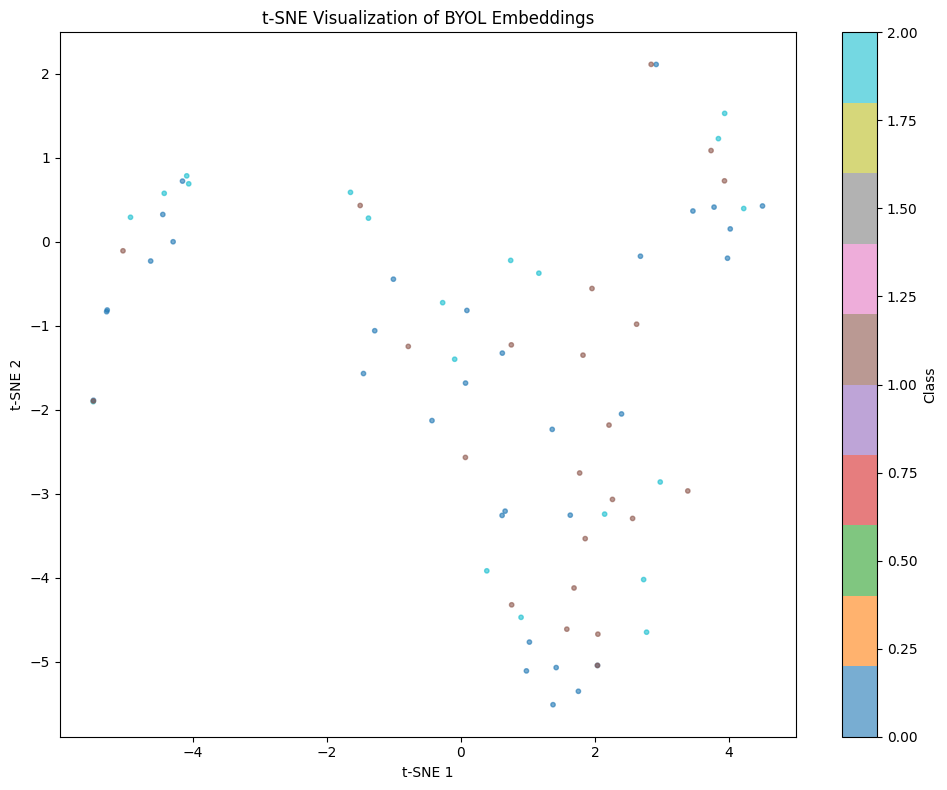

t-SNE Silhouette Score: -0.0606


In [21]:
def plot_tsne(features, labels, n_samples=5000):
    """
    t-SNE visualization of embeddings.
    Automatically adjusts sample size if dataset is smaller than n_samples.
    """
    print("\n=== t-SNE Visualization ===")

    total_samples = len(features)

    # Adjust n_samples automatically
    if n_samples > total_samples:
        print(f"[INFO] Requested n_samples={n_samples}, but dataset has only {total_samples}.")
        n_samples = total_samples
        print(f"[INFO] Using n_samples={n_samples} instead.")

    # Subsample
    indices = np.random.choice(total_samples, n_samples, replace=False)
    features_sub = features[indices]
    labels_sub = labels[indices]

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features_sub)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=labels_sub, cmap='tab10',
        alpha=0.6, s=10
    )
    plt.colorbar(scatter, label='Class')
    plt.title('t-SNE Visualization of BYOL Embeddings')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.savefig('tsne_byol.png', dpi=150)
    plt.show()

    # Silhouette Score
    sil_score = silhouette_score(features_2d, labels_sub)
    print(f"t-SNE Silhouette Score: {sil_score:.4f}")

    return features_2d, sil_score



tsne_features, tsne_sil = plot_tsne(X_test, y_test)


# 5.3 Embedding Analysis - UMAP

In [31]:
import umap.umap_ as umap_module

_original_check_array = umap_module.check_array

# Create a wrapper that removes ensure_all_finite
def _patched_check_array(X, **kwargs):
    if "ensure_all_finite" in kwargs:
        kwargs.pop("ensure_all_finite")
    return _original_check_array(X, **kwargs)

# Patch UMAP globally
umap_module.check_array = _patched_check_array

print("UMAP check_array patched successfully.")


UMAP check_array patched successfully.



=== UMAP Visualization ===
[INFO] Requested n_samples=5000, but dataset has only 75.
[INFO] Using n_samples=75 instead.


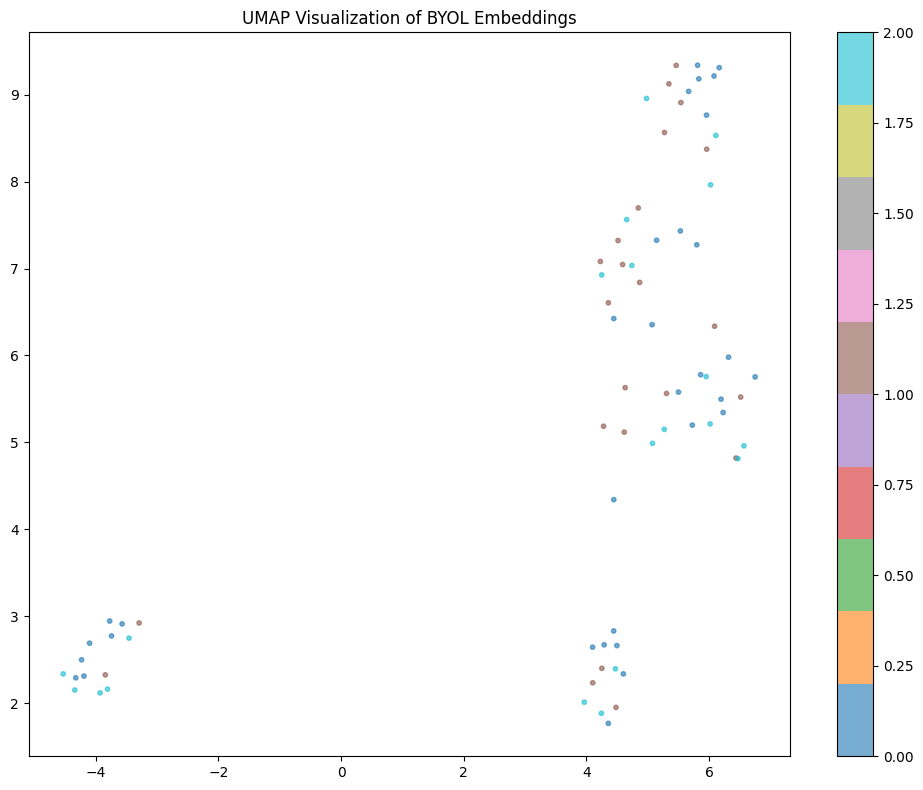

UMAP Silhouette Score: -0.0892


In [32]:
def plot_umap(features, labels, n_samples=5000):
    print("\n=== UMAP Visualization ===")

    total_samples = len(features)
    if n_samples > total_samples:
        print(f"[INFO] Requested n_samples={n_samples}, but dataset has only {total_samples}.")
        n_samples = total_samples
        print(f"[INFO] Using n_samples={n_samples} instead.")

    # Subsampling
    indices = np.random.choice(total_samples, n_samples, replace=False)

    features_sub = features[indices]
    labels_sub = labels[indices]

    reducer = UMAP(
        n_components=2,
        random_state=42,
        n_neighbors=15,
        min_dist=0.1
    )

    features_2d = reducer.fit_transform(features_sub)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        features_2d[:, 0], features_2d[:, 1],
        c=labels_sub, cmap='tab10', alpha=0.6, s=10
    )
    plt.colorbar(scatter)
    plt.title("UMAP Visualization of BYOL Embeddings")
    plt.tight_layout()
    plt.show()

    sil_score = silhouette_score(features_2d, labels_sub)
    print(f"UMAP Silhouette Score: {sil_score:.4f}")

    return features_2d, sil_score


umap_features, umap_sil = plot_umap(X_test, y_test)


# 5.3 Embedding Analysis - PCA


=== PCA Visualization ===


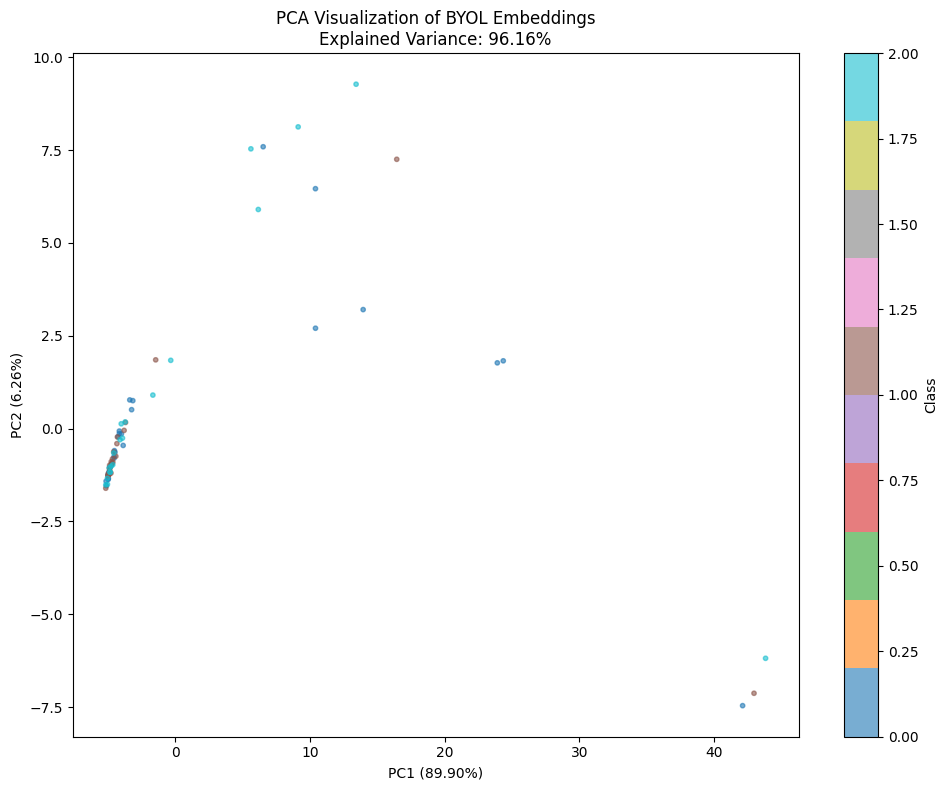

PCA Silhouette Score: -0.1176


In [33]:
def plot_pca(features, labels):
    """
    Create PCA visualization of embeddings colored by true labels
    """
    print("\n=== PCA Visualization ===")
    
    pca = PCA(n_components=2, random_state=42)
    features_2d = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                         c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Class')
    plt.title(f'PCA Visualization of BYOL Embeddings\n'
              f'Explained Variance: {pca.explained_variance_ratio_.sum():.2%}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.tight_layout()
    plt.savefig('pca_byol.png', dpi=150)
    plt.show()
    
    # Compute Silhouette score
    sil_score = silhouette_score(features_2d, labels)
    print(f"PCA Silhouette Score: {sil_score:.4f}")
    
    return features_2d, sil_score


pca_features, pca_sil = plot_pca(X_test, y_test)


# 5.4 Evaluation Metrics - Detailed Evaluation


=== Detailed Metrics ===
Overall Accuracy: 0.3600

Per-Class Metrics:
Class           Precision    Recall       F1-Score     Support     
---------------------------------------------------------------
Akbar           0.5000       0.4688       0.4839       32          
Dilkash         0.2759       0.3478       0.3077       23          
Urooj           0.2500       0.2000       0.2222       20          

Macro Avg       0.3420       0.3389       0.3379      


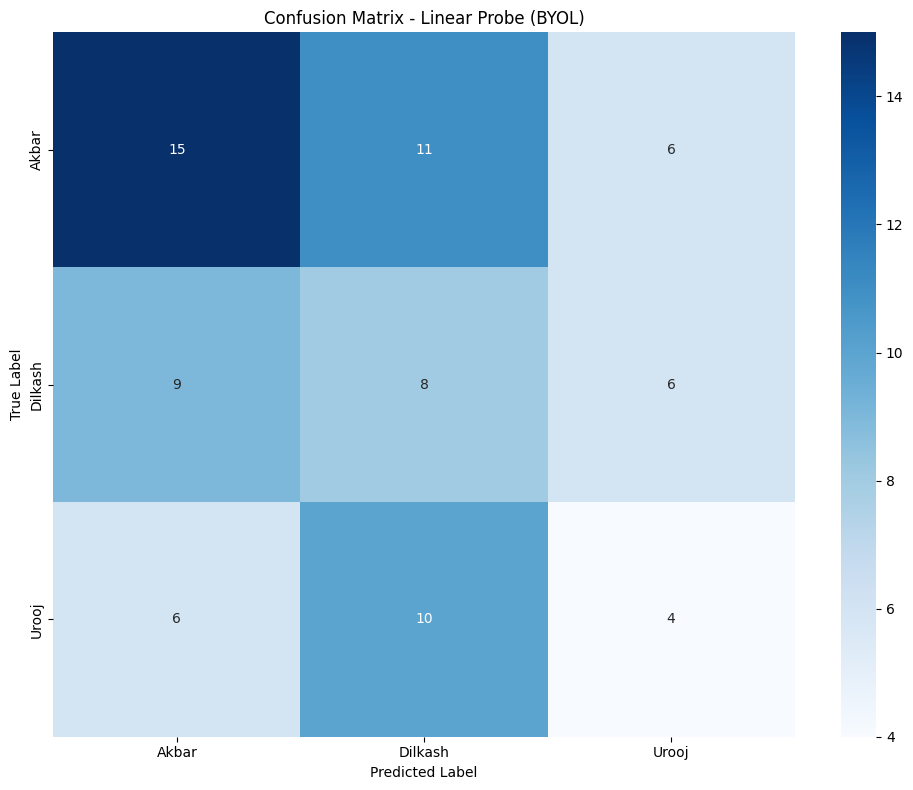

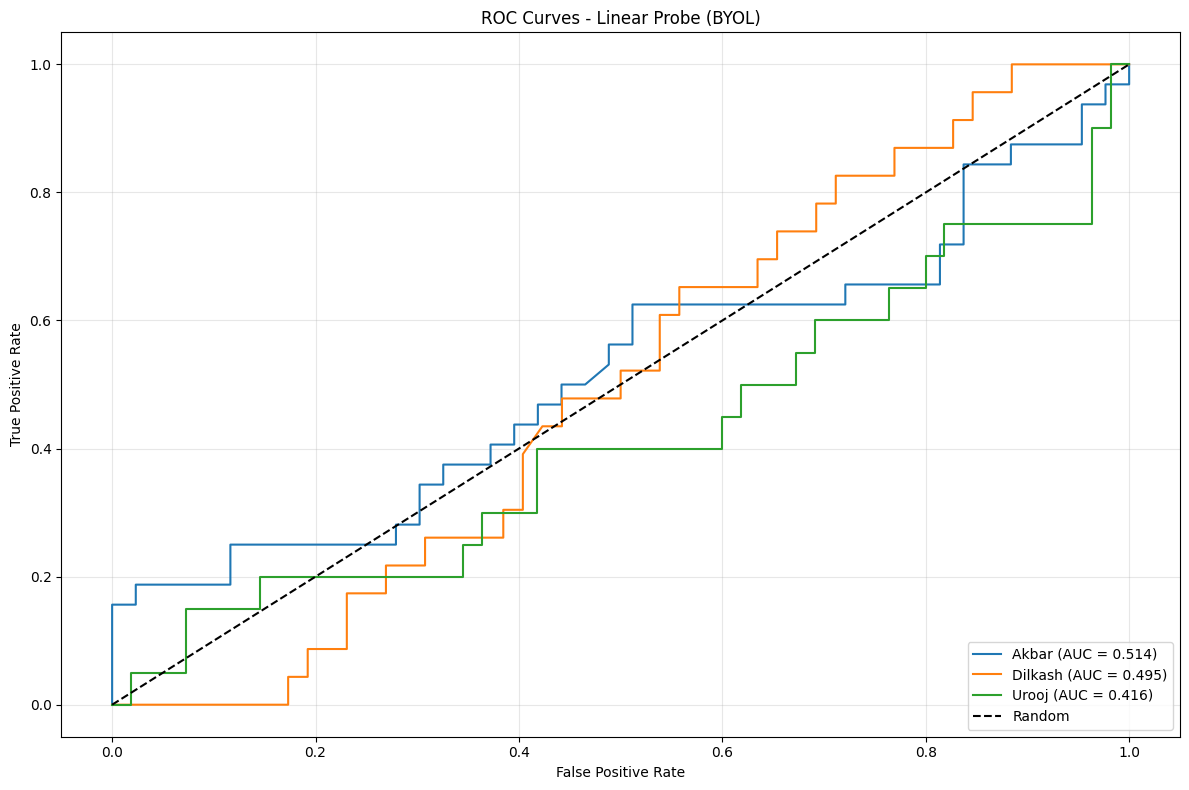


Average ROC-AUC: 0.4753


In [34]:

def compute_detailed_metrics(y_true, y_pred, y_pred_proba, class_names):
    """
    Compute comprehensive classification metrics
    """
    print("\n=== Detailed Metrics ===")
    
    # Overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )
    
    print("\nPer-Class Metrics:")
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-" * 63)
    for i, name in enumerate(class_names):
        print(f"{name:<15} {precision[i]:<12.4f} {recall[i]:<12.4f} "
              f"{f1[i]:<12.4f} {support[i]:<12}")
    
    # Macro averages
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro'
    )
    print(f"\n{'Macro Avg':<15} {prec_macro:<12.4f} {rec_macro:<12.4f} {f1_macro:<12.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Linear Probe (BYOL)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_byol.png', dpi=150)
    plt.show()
    
    # ROC-AUC and ROC Curves
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    
    # Compute ROC-AUC for each class
    roc_auc = {}
    plt.figure(figsize=(12, 8))
    
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Linear Probe (BYOL)')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('roc_curves_byol.png', dpi=150)
    plt.show()
    
    avg_roc_auc = np.mean(list(roc_auc.values()))
    print(f"\nAverage ROC-AUC: {avg_roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_roc_auc': avg_roc_auc,
        'confusion_matrix': cm
    }


class_names = ['Akbar', 'Dilkash', 'Urooj']

metrics = compute_detailed_metrics(y_test, linear_pred, linear_proba, class_names)

# 5.4 Evaluation Metrics K-NN Accuracy in Embedding Space

In [38]:
def evaluate_knn(X_train, y_train, X_test, y_test, k_values=[1, 5, 20]):
    """
    Evaluate k-NN classification in embedding space.
    This measures the quality of learned representations.
    """
    print("\n=== k-NN Evaluation ===")

    results = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results[k] = accuracy
        print(f"k={k}: Accuracy = {accuracy:.4f}")

    return results


knn_results = evaluate_knn(X_train, y_train, X_test, y_test)


=== k-NN Evaluation ===
k=1: Accuracy = 0.2800
k=5: Accuracy = 0.3467
k=20: Accuracy = 0.2667


# 5.4 Evaluation Metrics- Label Efficiency Curves


=== Label Efficiency Evaluation ===
1.0% labels (3 samples): Accuracy = 0.3467
5.0% labels (15 samples): Accuracy = 0.2400
10.0% labels (30 samples): Accuracy = 0.2400
25.0% labels (75 samples): Accuracy = 0.3733
50.0% labels (150 samples): Accuracy = 0.3867
100.0% labels (300 samples): Accuracy = 0.3600


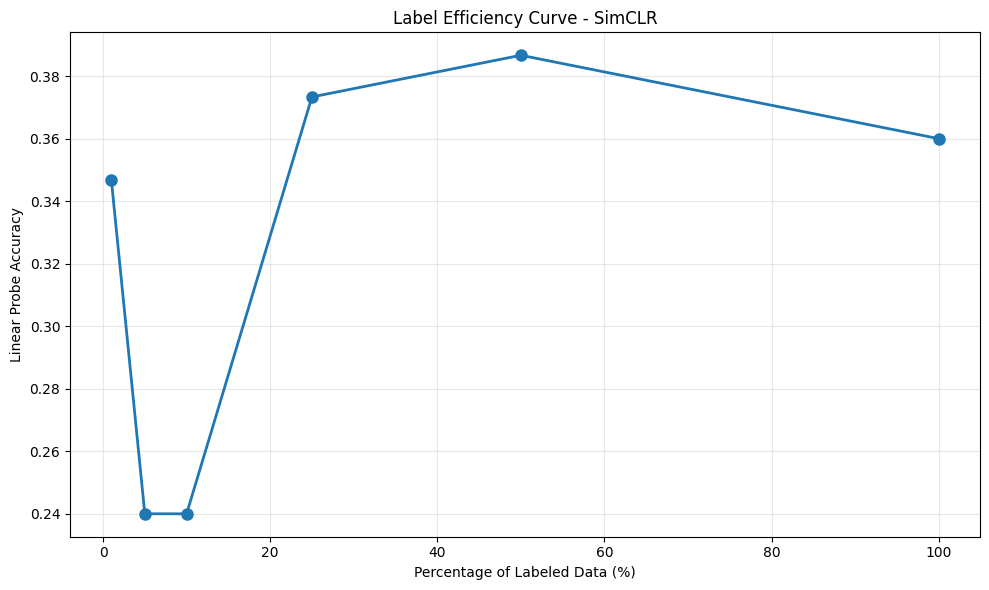

In [41]:
def evaluate_label_efficiency(X_train, y_train, X_test, y_test, fractions=[0.01, 0.05, 0.1, 0.25, 0.5, 1.0]):
    """
    Evaluate linear probe accuracy with different amounts of labeled data
    This shows how data-efficient the learned representations are
    """
    print("\n=== Label Efficiency Evaluation ===")
    
    results = {}
    
    for frac in fractions:
        n_samples = int(len(X_train) * frac)
        indices = np.random.choice(len(X_train), n_samples, replace=False)
        
        X_train_sub = X_train[indices]
        y_train_sub = y_train[indices]
        
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train_sub, y_train_sub)
        
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[frac] = accuracy
        print(f"{frac*100:.1f}% labels ({n_samples} samples): Accuracy = {accuracy:.4f}")
    

    plt.figure(figsize=(10, 6))
    fracs_pct = [f * 100 for f in results.keys()]
    accs = list(results.values())
    plt.plot(fracs_pct, accs, marker='o', linewidth=2, markersize=8)
    plt.xlabel('Percentage of Labeled Data (%)')
    plt.ylabel('Linear Probe Accuracy')
    plt.title('Label Efficiency Curve - SimCLR')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('label_efficiency_simclr.png', dpi=150)
    plt.show()
    
    return results
    
label_efficiency_results = evaluate_label_efficiency(X_train, y_train, X_test, y_test)


# 5.4 Evaluation Metrics- Learning Curves

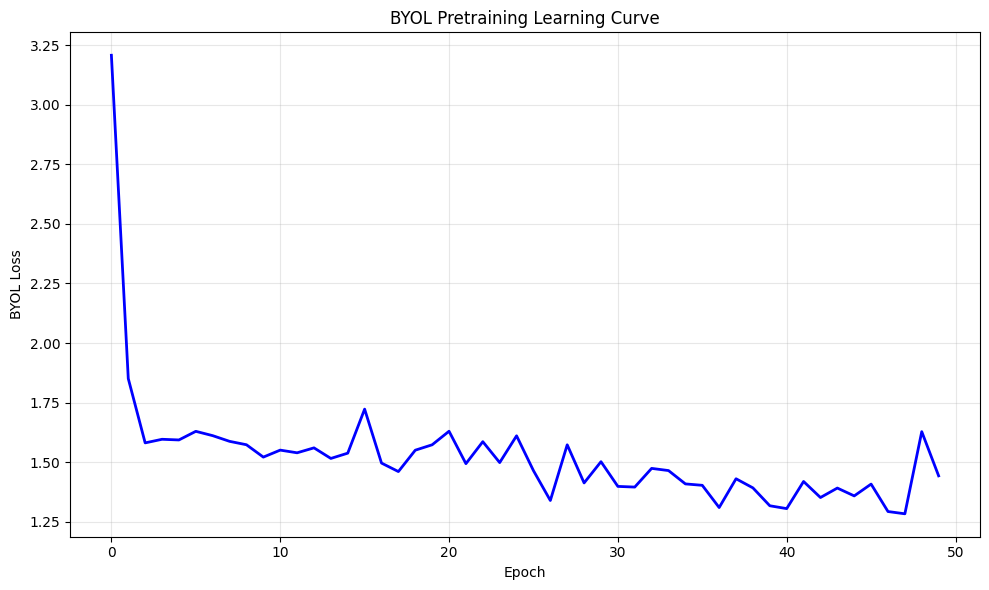

In [43]:
def plot_pretraining_curve(losses):
    """
    Plot the BYOL pretraining loss curve.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, linewidth=2, color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('BYOL Loss')
    plt.title('BYOL Pretraining Learning Curve')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pretraining_curve_byol.png', dpi=150)
    plt.show()


plot_pretraining_curve(pretrain_losses)

# Comprehensive Results Summary

In [45]:
print("\n" + "="*80)
print("                      BYOL COMPREHENSIVE RESULTS")
print("="*80)

print("\n--- PRETRAINING ---")
print(f"Epochs: 50")
print(f"Pretraining Time: {pretrain_time:.2f}s ({pretrain_time/60:.2f} min)")
print(f"Final Loss: {pretrain_losses[-1]:.4f}")

print("\n--- LINEAR PROBE (Primary SSL Metric) ---")
print(f"Accuracy: {linear_acc:.4f}")
print(f"Train Time: {lp_train_time:.2f}s")
print(f"Test Time: {lp_test_time:.2f}s")

print("\n--- SHALLOW HEADS ---")
for name, result in shallow_results.items():
    print(f"{name}: Accuracy = {result['accuracy']:.4f}, "
          f"Train Time = {result['train_time']:.2f}s")

print("\n--- FULL FINE-TUNING ---")
print(f"Accuracy: {finetune_acc:.4f}")
print(f"Improvement over Linear Probe: {(finetune_acc - linear_acc):.4f}")
print(f"Train Time: {ft_train_time:.2f}s ({ft_train_time/60:.2f} min)")

print("\n--- EMBEDDING QUALITY (Silhouette Scores) ---")
print(f"t-SNE: {tsne_sil:.4f}")
print(f"UMAP: {umap_sil:.4f}")
print(f"PCA: {pca_sil:.4f}")

print("\n--- k-NN ACCURACY ---")
for k, acc in knn_results.items():
    print(f"k={k}: {acc:.4f}")

print("\n--- LABEL EFFICIENCY ---")
for frac, acc in label_efficiency_results.items():
    print(f"{frac*100:.1f}% labels: {acc:.4f}")

print("\n--- DETAILED METRICS (Linear Probe) ---")
print(f"Average Precision: {metrics['precision'].mean():.4f}")
print(f"Average Recall: {metrics['recall'].mean():.4f}")
print(f"Average F1-Score: {metrics['f1'].mean():.4f}")
print(f"Average ROC-AUC: {metrics['avg_roc_auc']:.4f}")

print("\n" + "="*80)



                      BYOL COMPREHENSIVE RESULTS

--- PRETRAINING ---
Epochs: 50
Pretraining Time: 94.26s (1.57 min)
Final Loss: 1.4433

--- LINEAR PROBE (Primary SSL Metric) ---
Accuracy: 0.3600
Train Time: 1.55s
Test Time: 0.01s

--- SHALLOW HEADS ---
MLP: Accuracy = 0.4133, Train Time = 1.44s
SVM: Accuracy = 0.2933, Train Time = 0.02s
DecisionTree: Accuracy = 0.3867, Train Time = 0.08s
RandomForest: Accuracy = 0.2800, Train Time = 0.27s

--- FULL FINE-TUNING ---
Accuracy: 0.3067
Improvement over Linear Probe: -0.0533
Train Time: 14.35s (0.24 min)

--- EMBEDDING QUALITY (Silhouette Scores) ---
t-SNE: -0.0606
UMAP: -0.0892
PCA: -0.1176

--- k-NN ACCURACY ---
k=1: 0.2800
k=5: 0.3467
k=20: 0.2667

--- LABEL EFFICIENCY ---
1.0% labels: 0.3467
5.0% labels: 0.2400
10.0% labels: 0.2400
25.0% labels: 0.3733
50.0% labels: 0.3867
100.0% labels: 0.3600

--- DETAILED METRICS (Linear Probe) ---
Average Precision: 0.3420
Average Recall: 0.3389
Average F1-Score: 0.3379
Average ROC-AUC: 0.4753



# Comparison Table Preparation

In [47]:
byol_results = {
    'Method': 'BYOL',

    # Pretraining
    'Pretrain_Time_min': pretrain_time / 60,
    'Pretrain_Loss': pretrain_losses[-1],

    # Linear Probe (Primary Metric)
    'Linear_Probe_Acc': linear_acc,
    'LP_Train_Time_s': lp_train_time,
    'LP_Test_Time_s': lp_test_time,

    # Shallow Heads
    'MLP_Acc': shallow_results['MLP']['accuracy'],
    'SVM_Acc': shallow_results['SVM']['accuracy'],
    'DecisionTree_Acc': shallow_results['DecisionTree']['accuracy'],
    'RandomForest_Acc': shallow_results['RandomForest']['accuracy'],

    # Fine-tuning
    'FineTune_Acc': finetune_acc,
    'FineTune_Gain': finetune_acc - linear_acc,
    'FT_Train_Time_min': ft_train_time / 60,

    # Embedding Quality
    'tSNE_Silhouette': tsne_sil,
    'UMAP_Silhouette': umap_sil,
    'PCA_Silhouette': pca_sil,

    # k-NN Accuracy
    'kNN_k1': knn_results[1],
    'kNN_k5': knn_results[5],
    'kNN_k20': knn_results[20],

    # Label Efficiency
    'Label_1pct': label_efficiency_results[0.01],
    'Label_5pct': label_efficiency_results[0.05],
    'Label_10pct': label_efficiency_results[0.1],
    'Label_25pct': label_efficiency_results[0.25],
    'Label_50pct': label_efficiency_results[0.5],

    # Detailed Metrics
    'Avg_Precision': metrics['precision'].mean(),
    'Avg_Recall': metrics['recall'].mean(),
    'Avg_F1': metrics['f1'].mean(),
    'Avg_ROC_AUC': metrics['avg_roc_auc'],


}


df_results = pd.DataFrame([byol_results]).T
df_results.columns = ['Value']


print("\n" + "="*80)
print("                  BYOL RESULTS FOR COMPARISON TABLE")
print("="*80)
print(df_results.to_string())



                  BYOL RESULTS FOR COMPARISON TABLE
                      Value
Method                 BYOL
Pretrain_Time_min  1.570961
Pretrain_Loss       1.44333
Linear_Probe_Acc       0.36
LP_Train_Time_s    1.547495
LP_Test_Time_s     0.006658
MLP_Acc            0.413333
SVM_Acc            0.293333
DecisionTree_Acc   0.386667
RandomForest_Acc       0.28
FineTune_Acc       0.306667
FineTune_Gain     -0.053333
FT_Train_Time_min  0.239137
tSNE_Silhouette   -0.060609
UMAP_Silhouette   -0.089186
PCA_Silhouette    -0.117609
kNN_k1                 0.28
kNN_k5             0.346667
kNN_k20            0.266667
Label_1pct         0.346667
Label_5pct             0.24
Label_10pct            0.24
Label_25pct        0.373333
Label_50pct        0.386667
Avg_Precision      0.341954
Avg_Recall         0.338859
Avg_F1             0.337928
Avg_ROC_AUC        0.475312


# Visualization of all Metrics Together

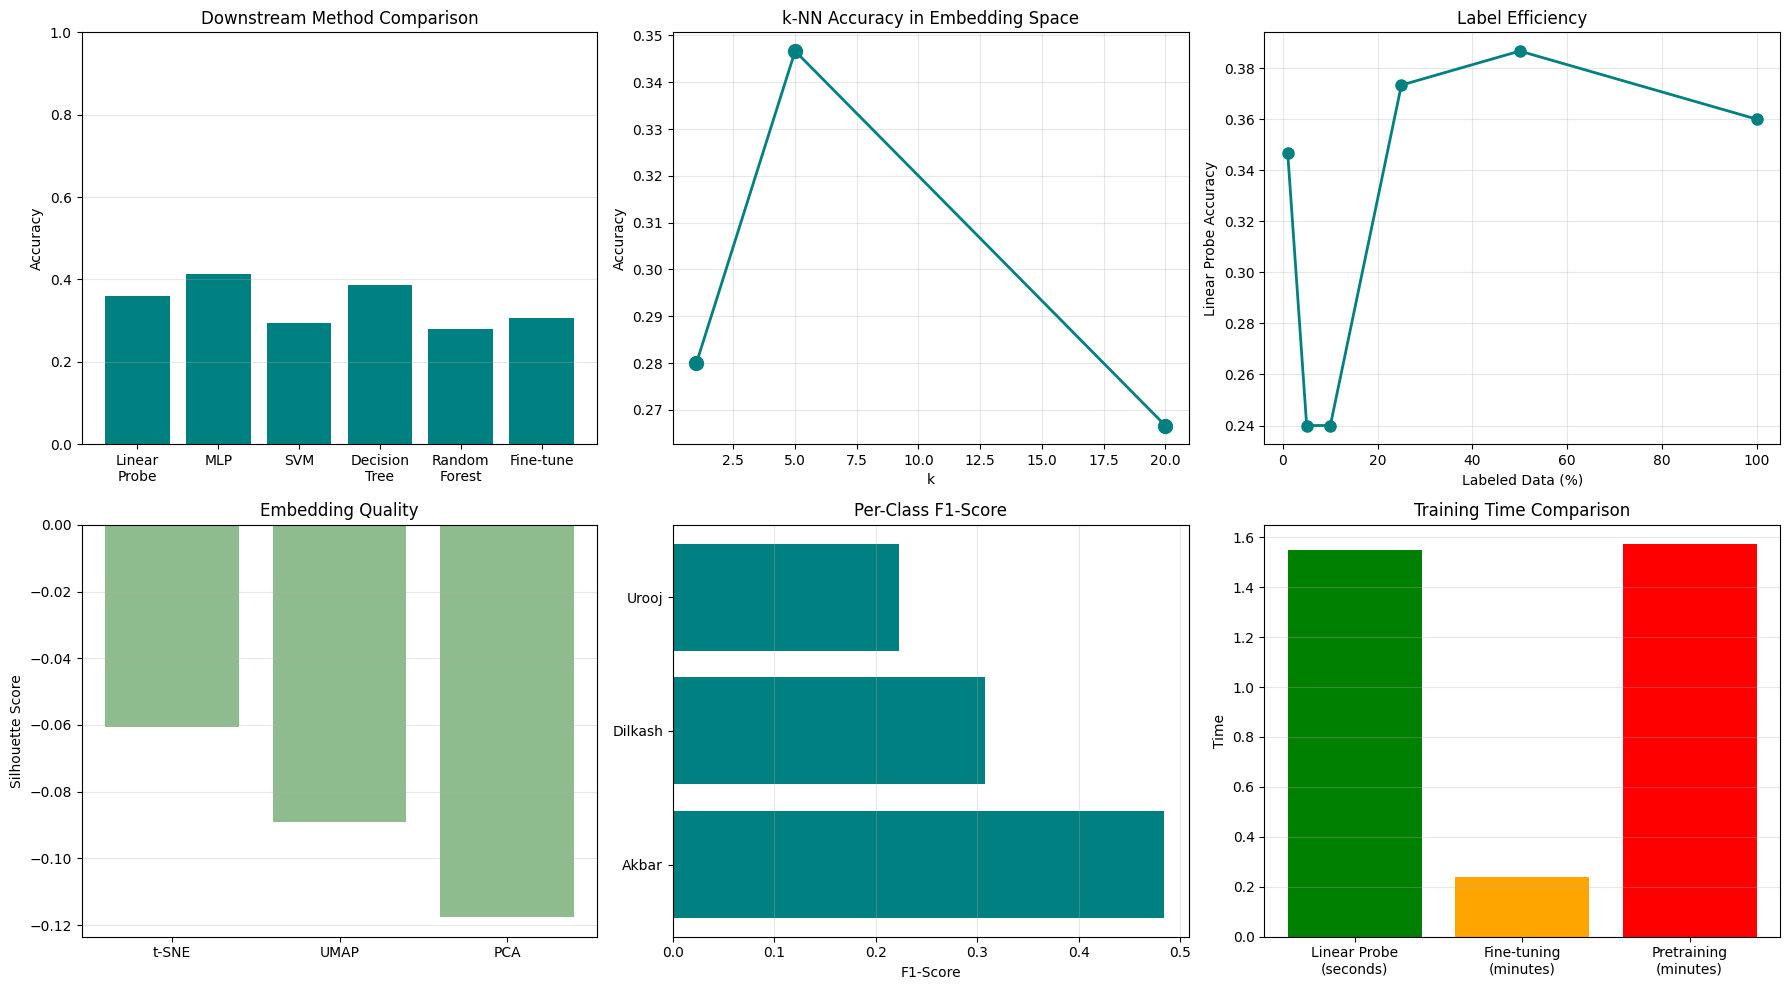

In [48]:
def plot_comprehensive_comparison():
    """
    Create comprehensive visualization of all evaluation metrics for BYOL.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    methods = ['Linear\nProbe', 'MLP', 'SVM', 'Decision\nTree', 
               'Random\nForest', 'Fine-tune']
    accuracies = [
        linear_acc,
        shallow_results['MLP']['accuracy'],
        shallow_results['SVM']['accuracy'],
        shallow_results['DecisionTree']['accuracy'],
        shallow_results['RandomForest']['accuracy'],
        finetune_acc
    ]
    axes[0, 0].bar(methods, accuracies, color='teal')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Downstream Method Comparison')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(axis='y', alpha=0.3)

    k_vals = list(knn_results.keys())
    k_accs = list(knn_results.values())
    axes[0, 1].plot(k_vals, k_accs, marker='o', linewidth=2, markersize=10, color='teal')
    axes[0, 1].set_xlabel('k')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('k-NN Accuracy in Embedding Space')
    axes[0, 1].grid(alpha=0.3)

    fracs = [f * 100 for f in label_efficiency_results.keys()]
    le_accs = list(label_efficiency_results.values())
    axes[0, 2].plot(fracs, le_accs, marker='o', linewidth=2, markersize=8, color='teal')
    axes[0, 2].set_xlabel('Labeled Data (%)')
    axes[0, 2].set_ylabel('Linear Probe Accuracy')
    axes[0, 2].set_title('Label Efficiency')
    axes[0, 2].grid(alpha=0.3)

    emb_methods = ['t-SNE', 'UMAP', 'PCA']
    sil_scores = [tsne_sil, umap_sil, pca_sil]
    axes[1, 0].bar(emb_methods, sil_scores, color='darkseagreen')
    axes[1, 0].set_ylabel('Silhouette Score')
    axes[1, 0].set_title('Embedding Quality')
    axes[1, 0].grid(axis='y', alpha=0.3)

    axes[1, 1].barh(class_names, metrics['f1'], color='teal')
    axes[1, 1].set_xlabel('F1-Score')
    axes[1, 1].set_title('Per-Class F1-Score')
    axes[1, 1].grid(axis='x', alpha=0.3)

    times = [lp_train_time, ft_train_time/60, pretrain_time/60]
    time_labels = ['Linear Probe\n(seconds)', 'Fine-tuning\n(minutes)', 'Pretraining\n(minutes)']
    colors = ['green', 'orange', 'red']
    axes[1, 2].bar(time_labels, times, color=colors)
    axes[1, 2].set_ylabel('Time')
    axes[1, 2].set_title('Training Time Comparison')
    axes[1, 2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_comprehensive_comparison()
